In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.utils as utils
from torch.nn.functional import softmax
from torch import bmm
import random
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import numpy as np
import sys
import torch.optim as optim
import os
import pandas as pd
import time
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

os.system('mkdir ./data')
os.system('mkdir ./checkpoint')
os.system('mkdir ./attention')
if not os.path.exists('./drive/MyDrive/datasets/11-785-s20-hw4p2.zip'):
    print('zip doesn\'t exist')
else:
    os.system('cp ./drive/MyDrive/datasets/11-785-s20-hw4p2.zip ./data/')
    os.system('unzip ./data/11-785-s20-hw4p2.zip')
    os.system('mv ./dev_new.npy ./data/')
    os.system('mv ./dev_transcripts.npy ./data/')
    os.system('mv ./test_new.npy ./data/')
    os.system('mv ./test_sample_submission.csv ./data/')
    os.system('mv ./train_new.npy ./data/')
    os.system('mv ./train_transcripts.npy ./data/')

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# 1 数据预处理

## 1.1 构建词典
全局常量LETTER_LIST包含了输出序列中所有可能出现的字母与符号。create_dictionaries()函数返回两个字典letter2index和index2letter，前者可以通过符号索引它在LETTER_LIST中的位置，在数据预处理中会用到；后者与LETTER_LIST相同。

In [ ]:
LETTER_LIST = ['<pad>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
               'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '-', "'", '.', '_', '+', ' ','<sos>','<eos>']

In [ ]:
'''
Optional, create dictionaries for letter2index and index2letter transformations
'''
def create_dictionaries(letter_list):
    length = len(letter_list)
    letter2index = {letter_list[i]:i for i in range(length)}
    index2letter = {i:letter_list[i] for i in range(length)}  # 深拷贝
    return letter2index, index2letter

letter2index, index2letter = create_dictionaries(LETTER_LIST)

## 1.2 读取数据集
load_data()函数用于从数据集中读取.npy文件并以np.array的格式返回。这个函数由[CMU 11-785 recitation](https://www.youtube.com/watch?v=02MjLlTuF3U&list=PLp-0K3kfddPwEwFEWePq10blIIneuP8ox&index=12)提供。

In [ ]:
'''
Loading all the numpy files containing the utterance information and text information
'''
def load_data(dataDir='./data/'):
    speech_train = np.load(dataDir+"train_new.npy", allow_pickle=True, encoding='bytes')
    speech_dev = np.load(dataDir+"dev_new.npy", allow_pickle=True, encoding='bytes')
    speech_test = np.load(dataDir+"test_new.npy", allow_pickle=True, encoding='bytes')

    transcript_train = np.load(dataDir+"train_transcripts.npy", allow_pickle=True, encoding='bytes')
    transcript_dev = np.load(dataDir+"dev_transcripts.npy", allow_pickle=True, encoding='bytes')

    return speech_train, transcript_train, speech_dev, transcript_dev, speech_test

In [ ]:
# 调用load_data()，得到训练数据
speech_train, transcript_train, speech_dev, transcript_dev, speech_test = load_data()

我们可以查看数据集大小及其中一条数据的内容：

In [ ]:
print('Training set size:{}, {}'.format(speech_train.shape, transcript_train.shape))
print('Development set size:{}, {}'.format(speech_dev.shape, transcript_dev.shape))
print('Test set size:{}'.format(speech_test.shape))

Training set size:(24724,), (24724,)
Development set size:(1106,), (1106,)
Test set size:(523,)


In [ ]:
speech_train[0], transcript_train[0]  # b stands for numpy.bytes_

(array([[-4.5242844, -5.708006 , -7.4425936, ..., -8.267208 , -3.5986276,
         -8.46898  ],
        [-4.960453 , -5.7416215, -7.937359 , ..., -8.147214 , -4.614257 ,
         -7.7562113],
        [-5.3406754, -5.157624 , -8.336189 , ..., -7.606736 , -5.0494947,
         -7.9340124],
        ...,
        [-5.2470493, -5.99119  , -4.6648097, ..., -5.8244734, -3.8987803,
         -5.8652916],
        [-6.0679326, -5.1122055, -5.5143185, ..., -6.347003 , -4.585992 ,
         -8.402996 ],
        [-6.1676664, -5.1596828, -6.365869 , ..., -6.225582 , -4.6173177,
         -7.6886425]], dtype=float32),
 array([b'THE', b'FEMALE', b'PRODUCES', b'A', b'LITTER', b'OF', b'TWO',
        b'TO', b'FOUR', b'YOUNG', b'IN', b'NOVEMBER', b'AND', b'DECEMBER'],
       dtype='|S8'))

## 1.3 转换数据
由于LETTER_LIST中\<sos\>、\<eos\>过长，为便于训练，使用transform_letter_to_index()函数将训练集和验证集中的文字转换为int类型的列表。

In [ ]:
def transform_letter_to_index(transcript):
    '''
    :param transcript :(N, ) Transcripts are the text input
    :param letter_list: Letter list defined above
    :return letter_to_index_list: Returns a list for all the transcript sentence to index
    '''
    letter_to_index_list = []
    for sentence in transcript:
        idxs = [letter2index['<sos>']]
        for word in sentence:
            word_str = word.decode('utf-8')  # 从字节编码转换为string
            for ch in word_str:
                idxs.append(letter2index[ch])
            idxs.append(letter2index[' ']) # 每两个词之间有空格
        idxs.pop()
        idxs.append(letter2index['<eos>']) # 处理完一个句子
        letter_to_index_list.append(idxs)
    return letter_to_index_list

由于训练的时候transcript使用数字表示，在输出的时候应该将其转化回字母和符号。使用transform_index_to_letter()函数实现了这一转换。

In [ ]:
def transform_index_to_letter(index):
    index_to_letter_list = []
    for r in index:
        letters = ""
        for i in r:
            if index2letter[i] == '<eos>' or index2letter[i] == '<pad>':
                break
            else:
                letters += index2letter[i]
        index_to_letter_list.append(letters)
    return index_to_letter_list

调用transform_letter_to_index()函数，将数据集转化成要输入的形式：

In [ ]:
text_train_idxs = transform_letter_to_index(transcript_train)
text_dev_idxs = transform_letter_to_index(transcript_dev)

## 1.4 数据集类
Speech2TextDataset类继承自torch.utils.data.Dataset类，通过重写\_\_getitem\_\_()方法，允许通过下标直接获得训练数据及其标签（如果有的话）。

In [ ]:
class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours.
    '''
    def __init__(self, speech, text, isTrain=True):
        self.dataX = speech
        self.dataY = text
        self.isTrain = isTrain

    def __len__(self):
        return self.dataX.shape[0]

    def __getitem__(self, index):
        if self.isTrain:  # 训练集包括数据和label
            return torch.tensor(self.dataX[index].astype(np.float32)), torch.tensor(self.dataY[index])
        else:  # 测试集只有数据，没有label
            return torch.tensor(self.dataX[index].astype(np.float32))

In [ ]:
train_dataset = Speech2TextDataset(speech_train, text_train_idxs, isTrain=True)
dev_dataset = Speech2TextDataset(speech_dev, text_dev_idxs, isTrain=True)
test_dataset = Speech2TextDataset(speech_test, text=None, isTrain=False)

## 1.5 数据对齐

In [ ]:
def collate_train(batch):
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    padded_inputs, input_lens = [], []
    padded_targets, target_lens = [], []
    l = len(batch)
    for i in range(l):
        padded_inputs.append(torch.tensor(batch[i][0]))
        padded_targets.append(torch.tensor(batch[i][1][1:])) # 不取<sos>
        input_lens.append(len(batch[i][0]))
        target_lens.append(len(batch[i][1])-1) #  sentence <eos>
    padded_inputs = pad_sequence(padded_inputs, batch_first=True) # dim (B, T, C) since batch_first is true, (T, B, C) if false
    padded_targets = pad_sequence(padded_targets, batch_first=True)
    return padded_inputs, padded_targets, torch.tensor(input_lens), torch.tensor(target_lens)

def collate_test(batch):
    ### Return padded speech and length of utterance ###
    padded_inputs, input_lens = [], []
    l = len(batch)
    for b in range(l):
        padded_inputs.append(torch.tensor(batch[b]))
        input_lens.append(len(batch[b]))
    padded_inputs = pad_sequence(padded_inputs, batch_first=True)
    return padded_inputs, torch.tensor(input_lens)

## 1.6 获取DataLoader
torch.nn.data.DataLoader类返回数据迭代器。参数collate_fn将一系列样本合并并返回小批量tensor。

In [ ]:
BATCH_SIZE = 64 if DEVICE=='cuda' else 1

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_train) # 训练集，387个batch
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_train) # 验证集，18个batch
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_test) # 测试集，9个batch

# 2 模型
模型由五个类组成，分别是Attention，Encoder，Decoder，PBLSTM, LAS，其中LAS为包装类。部分代码框架由recitation给出，实现过程中保留了相关英文注释。

注意力机制

In [ ]:
class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(N, context_size) Query is the output of LSTMCell from Decoder
        :param key: (N, T_max, key_size) Key Projection from Encoder per time step
        :param value: (N, T_max, value_size) Value Projection from Encoder per time step
        :param lens: (N, T) Length of key and value, used for binary masking
        :return output: Attended Context
        :return attention: Attention mask that can be plotted
        '''
        # binary masking for padded positions
        mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1) # (1, T_max) >= (B, 1) -> (N, T_max)
        mask = mask.to(DEVICE)

        # print("key_size:{}".format(key.size()))  # torch.Size([64, 256, 128])
        # print("query_size:{}".format(query.size()))  # torch.Size([64, 128])
        # batch matrix multiplication
        energy = bmm(key, query.unsqueeze(2)) # (batch, T_max, key_size) * (batch, context_size, 1) = (batch, T_max, 1)
        energy = energy.squeeze(2)  # (N, T_max)
        # print('energy_size:{}'.format(energy.size()))  # torch.Size([64, 256])
        energy.masked_fill_(mask, -1e9) # (N, T_max)
        attention = softmax(energy, dim=1) # (N, T_max)
        # print('attention_size:{}'.format(attention.size()))    # torch.Size([64, 256])
        context = bmm(attention.unsqueeze(1), value).squeeze(1) # (N, T_max)

        return context, attention

pBLSTM结构是模型Encoder部分的核心。它的物理结构是一个单层的双向LSTM网络，但是在前向传播的过程中，每层网络将输入维度减半而维度不总是偶数，因此需要去除多余的序列。

In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)

    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM
        '''
        x_padded, x_lens = pad_packed_sequence(x, batch_first=True)
        x_padded = x_padded[:, :(x_padded.size(1)//2)*2, :] # (B, T, dim); 长度不一定是2的倍数
        x_reshaped = x_padded.reshape(x_padded.size(0), x_padded.size(1)//2, x_padded.size(2)*2) # reshape to (B, T/2, dim*2),长度减半
        x_packed = pack_padded_sequence(x_reshaped, lengths=(x_lens//2).cpu(), batch_first=True, enforce_sorted=False)  # （B, T/2, input_dim）
        output, _ = self.blstm(x_packed)

        return output

编码器接收语料为输入，输出key-value对，它们就是对pBLSTM网络输出的简单映射。

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=128, key_size=128):
        super(Encoder, self).__init__()
        # 底层LSTM
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)

        ### Add code to define the blocks of pBLSTMs! ###
        # 3层pBLSTM
        self.pBLSTMs = nn.Sequential(
            pBLSTM(hidden_dim*4, hidden_dim),
            pBLSTM(hidden_dim*4, hidden_dim),
            pBLSTM(hidden_dim*4, hidden_dim)
        )

        self.key_network = nn.Linear(hidden_dim*2, value_size)
        self.value_network = nn.Linear(hidden_dim*2, key_size)

    def forward(self, x, lens):
        rnn_inp = pack_padded_sequence(x, lengths=lens.cpu(), batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(rnn_inp)

        ### Use the outputs and pass it through the pBLSTM blocks! ###
        outputs = self.pBLSTMs(outputs)

        linear_input, encoder_lens = pad_packed_sequence(outputs, batch_first=True)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)
        return keys, value, encoder_lens

解码器(Speller)对输入序列进行预测。

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step,
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, value_size=128, key_size=128, isAttended=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm1 = nn.LSTMCell(input_size=embed_dim+value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_size)
        self.character_prob = nn.Linear(key_size+value_size, vocab_size)
        self.value_size = value_size
        self.hidden_dim = decoder_hidden_dim

        self.isAttended = isAttended
        if self.isAttended:
            self.attention = Attention()

    def forward(self, key, values, encoder_lens, epoch, batch_idx, text=None, isTrain=True):
        '''
        :param key :(N, T, key_size) Output of the Encoder Key projection layer
        :param values: (N, T, value_size) Output of the Encoder Value projection layer
        :param text: (N, text_len) Batch input of text with text_length
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability
        '''
        batch_size = key.shape[0]

        # 超参
        teacherForcingRate = 0.1
        isGumbel=True

        if isTrain:
            embeddings = self.embedding(text)
            max_len =  text.shape[1]
        else:
            max_len = 250

        predictions = []
        hidden_states = [None, None]
        prediction = torch.zeros(batch_size, 1).to(DEVICE)

        context = values[:, 0, :]  # initialize context
        attention_plot_list = []
        for i in range(max_len):
            # * Implement Gumble noise and teacher forcing techniques
            # * When attention is True, replace values[i,:,:] with the context you get from attention.
            # * If you haven't implemented attention yet, then you may want to check the index and break
            #   out of the loop so you do you do not get index out of range errors.

            if isTrain: # 训练模式
                # 首先决定是否使用teacher forcing technique
                rand = random.random()
                if rand <= teacherForcingRate:
                  isTF = True
                else:
                  isTF = False

                if isTF:  # 使用teacher forcing, 前一步的输出作为下一步的输入
                    if i != 0 and isGumbel:   # 添加gumbel noise，增强多样性
                        char_embed = torch.nn.functional.gumbel_softmax(prediction).mm(self.embedding.weight)
                    else:
                        char_embed = self.embedding(prediction.argmax(dim=-1))
                else:  # 不用teacher forcing, ground truth作为输入
                    if i == 0:
                        start_input = torch.zeros(batch_size, dtype=torch.long).fill_(letter2index['<sos>']).to(DEVICE)
                        char_embed = self.embedding(start_input)
                    else:
                        char_embed = embeddings[:, i-1, :]
            else:  # 测试或验证模式
                if i == 0:  # 开始：以<sos>作为输入
                    start_input = torch.zeros(batch_size, dtype=torch.long).fill_(letter2index['<sos>']).to(DEVICE)
                    char_embed = self.embedding(start_input)
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1))  # 概率最高的char作为输出

            # decoder的输入是将char_embed与context拼接
            input1 = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(input1, hidden_states[0])
            # print('hidden_states.shape:{}'.format(hidden_states[0].shape))
            input2 = hidden_states[0][0]
            hidden_states[1] = self.lstm2(input2, hidden_states[1]) # output (h_1, c_1)

            ### Compute attention from the output of the second LSTM Cell ###
            output = hidden_states[1][0]

            # 计算attention
            if self.isAttended:
                context, attention = self.attention(output, key, values, encoder_lens)  # 均为(batch_size, T_max)
                if batch_idx % 64 == 0 and isTrain:
                    cur_attention = attention[0].detach().cpu()
                    attention_plot_list.append(cur_attention)
            else:
                if i < values.size(1):
                    context = values[:, i, :]
                else:
                    context = torch.zeros(batch_size, self.value_size).to(DEVICE)
            # 预测
            prob_input = torch.cat([output, context],dim=1)
            prediction = self.character_prob(prob_input)
            predictions.append(prediction.unsqueeze(1))

        # Plot attention plot
        if batch_idx % 64 == 0 and isTrain:
            attentions = torch.stack(attention_plot_list, dim=1)
            plt.clf()
            sns.heatmap(attentions, cmap='Reds')  # heatmap并保存
            plt.savefig("./attention/heatE{}B{}.png".format(epoch,batch_idx))

        return torch.cat(predictions, dim=1)

最后使用LAS类对编码器和解码器进行包装。

In [ ]:
class LAS(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim=256, decoder_hidden_dim=512, embed_dim=256, value_size=128, key_size=128, isAttended=False):
        super(LAS, self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, value_size, key_size, isAttended)

    def forward(self, speech_input, speech_len, epoch, batchNum, text_input=None, isTrain=True):
        key, value, encoder_lens = self.encoder(speech_input, speech_len)
        if isTrain:   # 训练模式需要传入label
            predictions = self.decoder(key, value, encoder_lens, epoch, batchNum, text_input, isTrain=True)
        else:
            predictions = self.decoder(key, value, encoder_lens, epoch, batchNum, text=None, isTrain=False)
        return predictions

# 3 训练

## 3.1 掩码
由于在数据预处理阶段对音频进行了对齐处理，在计算损失时应该把这部分排除在外，掩码和pytorch的广播机制为实现提供了可能。

In [ ]:
def generate_mask(lens):
    # print('lens_size:{}'.format(lens.size()))  # N
    lens = torch.tensor(lens).to(DEVICE)  # N
    max_len = torch.max(lens)
    mask = (torch.arange(0, max_len).repeat(lens.size(0), 1).to(DEVICE) < lens.unsqueeze(1).expand(lens.size(0), max_len)).int()
    # print('generated_mask_size:{}'.format(mask.size()))  # torch.Size([64, 201]) in 1 training
    return mask

## 3.2 验证函数

In [ ]:
def calc_edit_dist(preds, targets):
    dist = 0.0
    for pred, target in zip(preds, targets):
        dist += torchaudio.functional.edit_distance(pred, target)
    return dist

In [ ]:
def eval_model(model, test_loader, criterion, epoch):
    ### Write your test code here! ###
    model.eval()
    model.to(DEVICE)
    LevDist, num_seq = 0.0, 0.0
    for batch_idx, (data, target, dataLens, targetLens) in enumerate(test_loader):
        data, target, dataLens, targetLens = data.to(DEVICE), target.to(DEVICE), dataLens.to(DEVICE), targetLens.to(DEVICE)
        predictions = model(data, dataLens, epoch, batch_idx, text_input=None, isTrain=False)

        # Compare validation edit distance
        pred = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy())
        target = transform_index_to_letter(target.detach().cpu().numpy())

        LevDist += calc_edit_dist(pred, target)
        # val_loss_list.append(LevDist)
        num_seq += len(pred)

        del data
        del target
        del dataLens
        del targetLens
        torch.cuda.empty_cache()

    return LevDist/num_seq, LevDist

## 3.3 超参数

In [ ]:
NUM_EPOCHS = 30
ENCODER_HIDDEN_DIM = 256
DECODER_HIDDEN_DIM = 512
EMBED_DIM = 256
VALUE_SIZE = 128
KEY_SIZE = 128
IS_ATTENDED = True
PRETRAINED = True  # 分多次训练或演示时置为True
CHECKPOINT_DIR = "./drive/MyDrive/checkpoints/"
SAVED_CHECKPOINT = "./drive/MyDrive/checkpoint/init_model29.txt"
SAVED_SCHEDULER = "./drive/MyDrive/checkpoint/init_scheduler29.txt"
TEST_PRED_CSV_PATH = './data/predicted_test.csv'
DEV_PRED_CSV_PATH = './data/predicted_dev.csv'
TEST_PRED_NPY_PATH = './data/predicted_test.npy'

## 3.4 定义模型、优化器、学习率调节器
使用LAS类对象作为模型，Adam作为优化器，ReduceLROnPlateau算法调节学习率。由于训练时直接使用edit distance作为损失函数会导致计算量大幅增加，且预测可以近似为每一个位置进行40分类问题，因此使用CE loss作为训练时的损失函数。

In [ ]:
model = LAS(input_dim=40, vocab_size=len(LETTER_LIST), encoder_hidden_dim=ENCODER_HIDDEN_DIM,
                decoder_hidden_dim=DECODER_HIDDEN_DIM,
                embed_dim=EMBED_DIM,
                value_size=VALUE_SIZE,
                key_size=KEY_SIZE,
                isAttended=IS_ATTENDED)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = calc_edit_dist
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.80, patience=1, verbose=True, threshold=1e-2)

若模型已经训练了一部分，恢复上次的参数：

In [ ]:
if PRETRAINED:
      checkpoint = torch.load(SAVED_CHECKPOINT)
      model.load_state_dict(checkpoint["model_state_dict"])
      model.to(DEVICE)
      optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      checkpoint = torch.load(SAVED_SCHEDULER)
      scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

model.to(DEVICE)

LAS(
  (encoder): Encoder(
    (lstm): LSTM(40, 256, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (2): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
    )
    (key_network): Linear(in_features=512, out_features=128, bias=True)
    (value_network): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(35, 256, padding_idx=0)
    (lstm1): LSTMCell(384, 512)
    (lstm2): LSTMCell(512, 128)
    (character_prob): Linear(in_features=256, out_features=35, bias=True)
    (attention): Attention()
  )
)

## 3.5 训练函数

In [ ]:
def train(model, train_loader, criterion, optimizer, epoch):
      # training mode
      model.train()
      model.to(DEVICE)
      trainingLoss, trainingPerplex = 0.0, 0.0
      # 1) Iterate through your loader
      for batch_idx, (data, target, dataLens, targetLens) in enumerate(train_loader):
          # 2) Use torch.autograd.set_detect_anomaly(True) to get notices about gradient explosion
          with torch.autograd.set_detect_anomaly(False):
              # 3) Set the inputs to the device.
              data, target, dataLens, targetLens = data.to(DEVICE), target.to(DEVICE), dataLens.to(DEVICE), targetLens.to(DEVICE)
              optimizer.zero_grad()

              # 4) Pass your inputs, and length of speech into the model.
              predictions = model(speech_input=data, speech_len=dataLens, epoch=epoch, batchNum=batch_idx, text_input=target, isTrain=True)

              # 5) Generate a mask based on the lengths of the text to create a masked loss.
              # 5.1) Ensure the mask is on the device and is the correct shape.
              mask = generate_mask(targetLens).to(DEVICE)

              # print('batch no.:{}'.format(batch_idx))
              # 7) Use the criterion to get the loss.
              loss = criterion(predictions.view(-1, predictions.size(2)), target.view(-1))
              # print('loss_size:{}'.format(loss.size()))
              # print(mask.size())
              # print(mask[3])
              # print(torch.sum(mask.view(-1)))
              # 8) Use the mask to calculate a masked loss.
              masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask) # 将mask flatten以计算内积
              # masked_loss = loss.sum() / targetLens.sum()

              ## Cumulate running loss and perplexity ##
              currLoss = masked_loss.item()
              currPerplex = torch.exp(masked_loss).item()
              trainingLoss += currLoss
              trainingPerplex += currPerplex

              # 9) Run the backward pass on the masked loss.
              masked_loss.backward()
              # 10) Use torch.nn.utils.clip_grad_norm(model.parameters(), 2)
              torch.nn.utils.clip_grad_norm(model.parameters(), 2)
              # 11) Take a step with your optimizer
              optimizer.step()

              del data
              del target
              del dataLens
              del targetLens
              torch.cuda.empty_cache()

      return trainingLoss/len(train_loader), trainingPerplex/len(train_loader)

In [ ]:
def train(model, train_loader, criterion, optimizer, epoch):
      # training mode
      model.train()
      model.to(DEVICE)
      trainingLoss, trainingPerplex = 0.0, 0.0
      # 1) Iterate through your loader
      for batch_idx, (data, target, dataLens, targetLens) in enumerate(train_loader):
          # 2) Use torch.autograd.set_detect_anomaly(True) to get notices about gradient explosion
          with torch.autograd.set_detect_anomaly(False):
              # 3) Set the inputs to the device.
              data, target, dataLens, targetLens = data.to(DEVICE), target.to(DEVICE), dataLens.to(DEVICE), targetLens.to(DEVICE)
              optimizer.zero_grad()

              # 4) Pass your inputs, and length of speech into the model.
              predictions = model(speech_input=data, speech_len=dataLens, epoch=epoch, batchNum=batch_idx, text_input=target, isTrain=True)

              # 5) Generate a mask based on the lengths of the text to create a masked loss.
              # 5.1) Ensure the mask is on the device and is the correct shape.
              mask = generate_mask(targetLens).to(DEVICE)

              # 7) Use the criterion to get the loss.
              loss = criterion(predictions.view(-1, predictions.size(2)), target.view(-1))

              # 8) Use the mask to calculate a masked loss.
              masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask) # 将mask flatten以计算内积
              ## Cumulate running loss and perplexity ##
              currLoss = masked_loss.item()
              currPerplex = torch.exp(masked_loss).item()
              trainingLoss += currLoss
              trainingPerplex += currPerplex

              # 9) Run the backward pass on the masked loss.
              masked_loss.backward()
              # 10) Use torch.nn.utils.clip_grad_norm(model.parameters(), 2)
              torch.nn.utils.clip_grad_norm(model.parameters(), 2)
              # 11) Take a step with your optimizer
              optimizer.step()

              del data
              del target
              del dataLens
              del targetLens
              torch.cuda.empty_cache()

      return trainingLoss/len(train_loader), trainingPerplex/len(train_loader)

In epoch 0,	 train_loss:1.91992	 train_perplexity:7.38317	
In epoch 1,	 train_loss:1.46708	 train_perplexity:4.35159	
Epoch 00003: reducing learning rate of group 0 to 8.0000e-04.
In epoch 2,	 train_loss:1.34399	 train_perplexity:3.84584	
In epoch 3,	 train_loss:1.24790	 train_perplexity:3.49374	
In epoch 4,	 train_loss:1.19581	 train_perplexity:3.31590	
Epoch 00006: reducing learning rate of group 0 to 6.4000e-04.
In epoch 5,	 train_loss:1.16169	 train_perplexity:3.20591	
In epoch 6,	 train_loss:1.11553	 train_perplexity:3.06004	
In epoch 7,	 train_loss:1.09693	 train_perplexity:3.00367	
In epoch 8,	 train_loss:1.07450	 train_perplexity:2.93757	
In epoch 9,	 train_loss:1.05214	 train_perplexity:2.87201	
Epoch 00011: reducing learning rate of group 0 to 5.1200e-04.
In epoch 10,	 train_loss:1.02101	 train_perplexity:2.78409	
In epoch 11,	 train_loss:0.94211	 train_perplexity:2.57175	
In epoch 12,	 train_loss:0.77783	 train_perplexity:2.18450	
In epoch 13,	 train_loss:0.56897	 train_perp

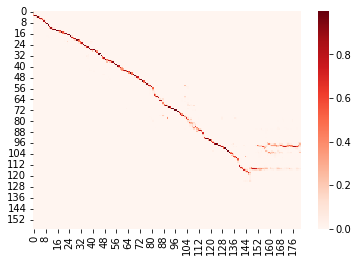

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_loss_list = []
train_perplex_list = []
val_loss_list = []

for epoch in range(NUM_EPOCHS):
      loss, perp = train(model, train_loader, criterion, optimizer, epoch)
      train_loss_list.append(loss)
      train_perplex_list.append(perp)

      # Save checkpoint
      path = "./drive/MyDrive/checkpoint/init_model{}.txt".format(epoch)
      torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()}, path)

      # Evaluate
      avgEditDist, _ = eval_model(model, dev_loader, criterion, epoch)
      val_loss_list.append(avgEditDist)
      scheduler.step(avgEditDist)
      torch.save({'epoch':epoch, 'scheduler_state_dict':scheduler.state_dict()}, "./drive/MyDrive/checkpoint/init_scheduler{}.txt".format(epoch))

      print('In epoch {},\t train_loss:{:.5f}\t train_perplexity:{:.5f}\t'.format(epoch, loss, perp))

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_loss_list = []
train_perplex_list = []
val_loss_list = []

for epoch in range(NUM_EPOCHS):
      loss, perp = train(model, train_loader, criterion, optimizer, epoch)
      train_loss_list.append(loss)
      train_perplex_list.append(perp)

      # Save checkpoint
      path = "./drive/MyDrive/init_epoch{}.txt".format(epoch)
      torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()}, path)

      # Evaluate
      avgEditDist, _ = eval_model(model, dev_loader, criterion, epoch)
      val_loss_list.append(avgEditDist)
      scheduler.step(avgEditDist)
      torch.save({'epoch':epoch, 'scheduler_state_dict':scheduler.state_dict()}, "./drive/MyDrive/init_scheduler{}.txt".format(epoch))

      print('In epoch {},\t train_loss:{:.5f}\t train_perplexity:{:.5f}\t'.format(epoch, loss, perp))

In epoch 0,	 train_loss:1.93423	 train_perplexity:7.47307	
Epoch 00027: reducing learning rate of group 0 to 7.5000e-04.
In epoch 1,	 train_loss:1.46864	 train_perplexity:4.36268	
In epoch 2,	 train_loss:1.31018	 train_perplexity:3.71919	
Epoch 00029: reducing learning rate of group 0 to 5.6250e-04.
In epoch 3,	 train_loss:1.23518	 train_perplexity:3.44986	
In epoch 4,	 train_loss:1.17447	 train_perplexity:3.24761	
Epoch 00031: reducing learning rate of group 0 to 4.2188e-04.
In epoch 5,	 train_loss:1.12685	 train_perplexity:3.09560	
In epoch 6,	 train_loss:1.02802	 train_perplexity:2.80638	
Epoch 00033: reducing learning rate of group 0 to 3.1641e-04.
In epoch 7,	 train_loss:0.69870	 train_perplexity:2.02823	
In epoch 8,	 train_loss:0.41548	 train_perplexity:1.51722	
Epoch 00035: reducing learning rate of group 0 to 2.3730e-04.
In epoch 9,	 train_loss:0.30824	 train_perplexity:1.36201	
In epoch 10,	 train_loss:0.23456	 train_perplexity:1.26483	
Epoch 00037: reducing learning rate of g

In [ ]:
import tarfile
import os
from google.colab import files

#逐个添加文件打包，未打包空子目录。可过滤文件。
#如果只打包不压缩，将"w:gz"参数改为"w:"或"w"即可。
def make_targz_one_by_one(output_filename, source_dir):
    tar = tarfile.open(output_filename,"w:gz")
    for root,dir_name,files_list in os.walk(source_dir):
      for file in files_list:
        pathfile = os.path.join(root, file)
        tar.add(pathfile)
    tar.close()
    os.system('mv attention3.zip drive/MyDrive/')

make_targz_one_by_one('attention3.zip', './attention/')

# 4 推断（预测）

In [ ]:
def inference(model, data_loader, csv_path, isValid=False):
    model.eval()
    model.to(DEVICE)
    res = []
    with torch.no_grad():
        if isValid:  # validation mode
            targetRes = []
            totalDist, num_seq = 0.0, 0.0
            for batch_idx, (data, target, dataLens, targetLens) in enumerate(data_loader):
                data, target, dataLens, targetLens = data.to(DEVICE), target.to(DEVICE), dataLens.to(DEVICE), targetLens.to(DEVICE)
                predictions = model(data, dataLens, 30, batch_idx, text_input=None, isTrain=False)

                # 计算edit dist
                predText = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy())  #使用最大prob的下标查表
                targetText = transform_index_to_letter(target.detach().cpu().numpy())
                totalDist += calc_edit_dist(predText, targetText)
                num_seq += len(predText)

                # 使用entend向list末尾追加多个元素
                # 不能用append，否则res的长度只会和batch的数量一样
                res.extend(predText)
                targetRes.extend(targetText)

            print("Average edit distance on validation set:\t{:.5f}".format(totalDist/num_seq))
            # print(num_seq)
            df = pd.DataFrame({"Id" : np.array([i for i in range(len(res))]), "Predicted" : np.array(res), "Target": np.array(targetRes)})
        else:
            for batch_idx, (data, dataLens) in enumerate(data_loader):
                data, dataLens = data.to(DEVICE), dataLens.to(DEVICE)
                predictions = model(data, dataLens, 30, batch_idx, text_input=None, isTrain=False)
                predText = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy())
                res.extend(predText)
            df = pd.DataFrame({"Id": np.array([i for i in range(len(res))]), "Predicted": np.array(res)})

        df.to_csv(csv_path, index=False)  # 输出csv
        return df

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 预测验证集
validInfer = inference(model, dev_loader, DEV_PRED_CSV_PATH, isValid=True)

# 预测测试集（提交kaggle）
testInfer = inference(model, test_loader, TEST_PRED_CSV_PATH, isValid=False)

Average edit distance on validation set:	16.98463


# 5 数据可视化

## 5.1 验证集预测结果

In [ ]:
validInfer

,Id,Predicted,Target
0,0,THE FEMALE PRODUCES A LITTER OF TWO TO FOUR YO...,THE FEMALE PRODUCES A LITTER OF TWO TO FOUR YO...
1,1,NUMEROUS WORKS OF ART ARE BASED ON THE STORY O...,NUMEROUS WORKS OF ART ARE BASED ON THE STORY O...
2,2,THEIR SOLUTION REQUIRES DEVELOPMENT OF THE HUM...,THEIR SOLUTION REQUIRES DEVELOPMENT OF THE HUM...
3,3,HIS MOST SIGNIFICANT SCIENTIFIC PUBLICATIONS W...,HIS MOST SIGNIFICANT SCIENTIFIC PUBLICATIONS W...
4,4,IN RECENT YEARS SHE HAS PRIMARILY APPEARED IN ...,IN RECENT YEARS SHE HAS PRIMARILY APPEARED IN ...
...,...,...,...
1101,1101,DOUBLE-QUOTE I THINK IT'S GRATE COMMA DOUBLE-Q...,DOUBLE-QUOTE I THINK IT'S GREAT COMMA DOUBLE-Q...
1102,1102,DOUBLE-QUOTE WE WERE THINKING THERE IS AN OBSI...,DOUBLE-QUOTE WE WERE THINKING THERE WAS AN OUT...
1103,1103,AND THEY TAP IN A PERIOD DOUBLE-QUOTE,AND IT HAPPENED PERIOD DOUBLE-QUOTE
1104,1104,THE HOUSE SELF FAR HAS PROPOSED TO OWLOWN HYPH...,THE HOUSE SO FAR HAS PROPOSED A LOAN HYPHEN GU...


## 5.2 训练集损失

0

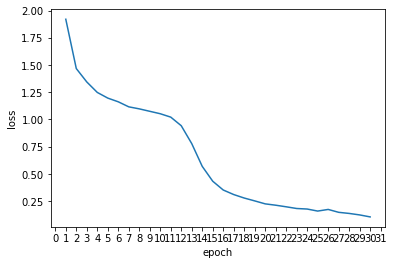

In [ ]:
train_loss_plot = pd.DataFrame({"loss":train_loss_list, "epoch":[i+1 for i in range(NUM_EPOCHS)]})

g = sns.lineplot(x = "epoch", y = "loss", data=train_loss_plot)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.savefig("./train_loss1.png")
os.system('mv ./train_loss1.png ./drive/MyDrive/')

## 5.3 验证集损失
验证集损失函数：编辑距离

0

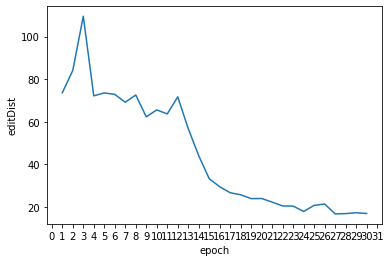

In [ ]:
val_loss_plot = pd.DataFrame({"editDist":val_loss_list, "epoch":[i+1 for i in range(NUM_EPOCHS)]})

gg = sns.lineplot(x = "epoch", y = "editDist", data=val_loss_plot)
gg.xaxis.set_major_locator(ticker.MultipleLocator(1))
gg.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.savefig("./val_loss1.png")
os.system('mv ./val_loss1.png ./drive/MyDrive/')

In [ ]:
train_loss_list

[1.9199213060605742,
 1.467084334802258,
 1.3439937977827796,
 1.2479048249641438,
 1.1958052400470705,
 1.161692036984811,
 1.115532400996186,
 1.0969257379379076,
 1.0744996201776411,
 1.0521430051295948,
 1.021010059872955,
 0.9421058187805097,
 0.7778306612672732,
 0.5689669388517237,
 0.4324039070643196,
 0.3517173083561643,
 0.30992693221076206,
 0.27797908772947866,
 0.25170066386692286,
 0.22442696337860069,
 0.21211441392584365,
 0.1974749419578286,
 0.18185141253301956,
 0.17692960739058733,
 0.1582444549684993,
 0.17329198655308986,
 0.1467479129516801,
 0.13659741257820326,
 0.1229156311168227,
 0.10457540091695096]

In [ ]:
val_loss_list

[73.623869801085,
 84.14376130198914,
 109.56781193490055,
 72.20524412296564,
 73.57685352622062,
 72.89602169981917,
 69.21428571428571,
 72.61030741410488,
 62.35171790235081,
 65.5994575045208,
 63.721518987341774,
 71.73236889692586,
 56.831826401446655,
 44.09493670886076,
 33.315551537070526,
 29.529837251356238,
 26.707956600361662,
 25.765822784810126,
 23.966546112115733,
 24.01627486437613,
 22.305605786618443,
 20.522603978300182,
 20.423146473779386,
 17.950271247739604,
 20.820976491862567,
 21.425858951175407,
 16.78481012658228,
 16.93399638336347,
 17.329113924050635,
 16.984629294755877]